<a href="https://colab.research.google.com/github/EdithOroche/IA/blob/main/Laboratorio07_Convoluciones2D_PyTorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Laboratorio: Convoluciones **2D** con PyTorch aplicando filtros clásicos

In [1]:
# === Configuración del entorno ===
import torch, torch.nn.functional as F
import numpy as np, matplotlib.pyplot as plt, os, urllib.request
from PIL import Image
from math import cos, sin, pi

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print("PyTorch:", torch.__version__, "| device:", device)

# ---------- Utilidades de I/O y visualización ----------
def pil_to_tensor01_rgb(pil_img):
    arr = np.array(pil_img).astype(np.float32) / 255.0  # HxWxC
    t = torch.from_numpy(arr).permute(2,0,1).unsqueeze(0)  # 1xCxHxW
    return t

def pil_to_tensor01_gray(pil_img):
    arr = np.array(pil_img.convert('RGB')).astype(np.float32) / 255.0
    r,g,b = arr[...,0], arr[...,1], arr[...,2]
    gray = 0.299*r + 0.587*g + 0.114*b
    t = torch.from_numpy(gray).unsqueeze(0).unsqueeze(0)  # 1x1xH xW
    return t

def tensor01_to_np_img(t):
    # t: 1xCxHxW en [0,1] -> numpy HxWxC (o HxW si C=1)
    t = t.detach().cpu().clamp(0,1)
    if t.shape[1] == 1:
        return t.squeeze(0).squeeze(0).numpy()
    else:
        return t.squeeze(0).permute(1,2,0).numpy()

def imshow_t(t, title=None, figsize=(5,5), cmap=None):
    img = tensor01_to_np_img(t)
    plt.figure(figsize=figsize)
    if img.ndim == 2:
        plt.imshow(img, cmap=cmap or 'gray', vmin=0, vmax=1)
    else:
        plt.imshow(img)
    if title: plt.title(title)
    plt.axis('off'); plt.show()

# ---------- Padding + conv2d helpers ----------
def conv2d_gray(inp, kernel, pad_mode='reflect', pad_value=0.0):
    # inp: tensor 1x1xHxW en [0,1]
    # kernel: tensor kxk (o khxkw)
    k = kernel.float().to(device)
    if k.ndim == 2:
        k = k.unsqueeze(0).unsqueeze(0)  # 1x1xkhxkw
    rH, rW = (k.shape[-2]//2, k.shape[-1]//2)
    x = F.pad(inp.to(device), (rW, rW, rH, rH), mode=pad_mode, value=pad_value)
    y = F.conv2d(x, k)
    return y

def conv2d_rgb(inp, kernel, pad_mode='reflect', pad_value=0.0):
    # inp: tensor 1x3xHxW, aplica mismo kernel por canal usando groups=3
    k = kernel.float().to(device)
    if k.ndim == 2:
        k = k.unsqueeze(0).unsqueeze(0)  # 1x1xkhxkw
    k3 = k.repeat(3,1,1,1)               # 3x1xkhxkw
    rH, rW = (k.shape[-2]//2, k.shape[-1]//2)
    x = F.pad(inp.to(device), (rW, rW, rH, rH), mode=pad_mode, value=pad_value)
    y = F.conv2d(x, k3, groups=3)
    return y

def normalize_kernel_sum1(k):
    s = k.sum()
    if abs(float(s)) < 1e-8:
        return k
    return k / s

def rescale01(t):
    m, M = t.min(), t.max()
    return (t - m) / (M - m + 1e-8)


PyTorch: 2.8.0+cu126 | device: cpu



## 1) Adquisición de imagen
Descargaremos una imagen pública y la cargaremos en **grises** y **color**. Puedes reemplazar la URL.


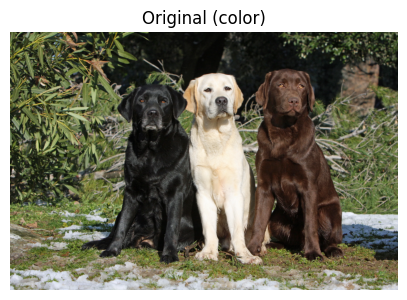

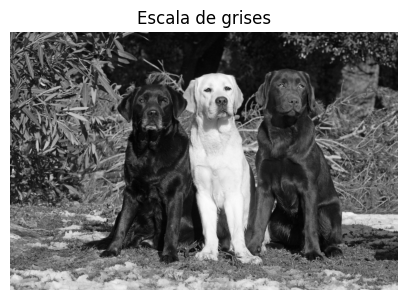

Tamaño: 2592 x 3888


In [2]:

os.makedirs("data", exist_ok=True)
url = "https://www.zooplus.es/magazine/wp-content/uploads/2019/04/labrador-3-Farben.webp"
local = "data/sample.jpg"
urllib.request.urlretrieve(url, local)

img_pil = Image.open(local).convert('RGB')
img_gray = pil_to_tensor01_gray(img_pil).to(device)
img_rgb  = pil_to_tensor01_rgb(img_pil).to(device)

imshow_t(img_rgb, "Original (color)")
imshow_t(img_gray, "Escala de grises")
h, w = img_gray.shape[-2:]
print("Tamaño:", h, "x", w)


## 2) Teoría: Convolución 2D discreta

Dadas una imagen $ f[m,n] $ y un kernel $h[i,j]$ de soporte finito, la **convolución 2D** se define como:
$$
(f * h)[m,n] = \sum_{i=-r}^{r}\sum_{j=-s}^{s} f[m-i, n-j]\; h[i,j].
$$
- En la definición **matemática** el kernel está **invertido** (reflejado) en ambos ejes.  
- En la práctica, muchos frameworks (incluido `F.conv2d`) implementan **correlación**; para kernels **simétricos** (caja/gauss) es equivalente.
- Los **modos de borde** (`reflect`, `replicate`, `constant`) determinan cómo extender la imagen para calcular los píxeles cercanos al borde.
- **Normalización**: para suavizados, suele imponerse $\sum h = 1$. Para detectores de bordes, típicos kernels **suman 0** (responden a cambios, no a DC).



## 3) Biblioteca de **kernels 2D** clásicos
Incluimos funciones para generar **muchos** filtros.


In [3]:

# ---------- Suavizado ----------
def box_kernel(k=3):
    k = int(k) if int(k)%2==1 else int(k)+1
    w = torch.ones((k,k), dtype=torch.float32)
    return normalize_kernel_sum1(w)

def gaussian1d(ksize=5, sigma=1.0):
    r = ksize//2
    x = torch.arange(-r, r+1, dtype=torch.float32)
    g = torch.exp(-(x**2)/(2*sigma**2))
    return g / g.sum()

def gaussian2d(ksize=5, sigma=1.0):
    g = gaussian1d(ksize, sigma)
    G = torch.outer(g, g)
    return G / G.sum()

# ---------- Derivadas / Bordes ----------
def sobel_kernels():
    kx = torch.tensor([[ -1., 0., 1.],
                       [ -2., 0., 2.],
                       [ -1., 0., 1.]])
    ky = torch.tensor([[ -1., -2., -1.],
                       [  0.,  0.,  0.],
                       [  1.,  2.,  1.]])
    return kx, ky

def prewitt_kernels():
    kx = torch.tensor([[ -1., 0., 1.],
                       [ -1., 0., 1.],
                       [ -1., 0., 1.]])
    ky = torch.tensor([[ -1., -1., -1.],
                       [  0.,  0.,  0.],
                       [  1.,  1.,  1.]])
    return kx, ky

def scharr_kernels():
    kx = torch.tensor([[ -3., 0., 3.],
                       [-10., 0.,10.],
                       [ -3., 0., 3.]])
    ky = torch.tensor([[ -3., -10., -3.],
                       [  0.,   0.,  0.],
                       [  3.,  10.,  3.]])
    return kx, ky

def roberts_kernels():
    kx = torch.tensor([[1., 0.],
                       [0., -1.]])
    ky = torch.tensor([[0., 1.],
                       [-1., 0.]])
    return kx, ky

# ---------- Laplacianos ----------
def laplacian4():
    return torch.tensor([[ 0., -1.,  0.],
                         [-1.,  4., -1.],
                         [ 0., -1.,  0.]])

def laplacian8():
    return torch.tensor([[-1., -1., -1.],
                         [-1.,  8., -1.],
                         [-1., -1., -1.]])

def log_kernel(ksize=9, sigma=1.4):
    # Laplaciano del Gaussiano (LoG) discreto
    r = ksize//2
    y,x = torch.meshgrid(torch.arange(-r,r+1), torch.arange(-r,r+1), indexing='ij')
    y = y.float(); x = x.float()
    norm = (x**2 + y**2)/(2*sigma**2)
    G = torch.exp(-norm)
    LoG = ( (x**2 + y**2 - 2*sigma**2) / (sigma**4) ) * G
    LoG = LoG - LoG.mean()  # suma cercana a 0
    return LoG

# ---------- Sharpen / Emboss / Outline ----------
def sharpen_basic():
    return torch.tensor([[ 0., -1.,  0.],
                         [-1.,  5., -1.],
                         [ 0., -1.,  0.]])

def outline():
    return torch.tensor([[-1., -1., -1.],
                         [-1.,  8., -1.],
                         [-1., -1., -1.]])

def emboss():
    return torch.tensor([[-2., -1., 0.],
                         [-1.,  1., 1.],
                         [ 0.,  1., 2.]])

# ---------- Motion blur ----------
def motion_blur_kernel(length=9, angle_deg=0.0):
    length = int(length) if int(length)%2==1 else int(length)+1
    k = torch.zeros((length, length), dtype=torch.float32)
    center = length//2
    theta = angle_deg * pi / 180.0
    dx, dy = cos(theta), sin(theta)
    for i in range(length):
        x = int(round(center + (i - center) * dx))
        y = int(round(center + (i - center) * dy))
        if 0 <= y < length and 0 <= x < length:
            k[y, x] = 1.0
    if k.sum() == 0:
        k[center, center] = 1.0
    return k / k.sum()

# ---------- Gabor ----------
def gabor_kernel(ksize=21, sigma=3.0, theta=0.0, lam=10.0, gamma=0.5, psi=0.0):
    r = ksize//2
    y,x = torch.meshgrid(torch.arange(-r,r+1), torch.arange(-r,r+1), indexing='ij')
    y = y.float(); x = x.float()
    xr =  x*torch.cos(theta) + y*torch.sin(theta)
    yr = -x*torch.sin(theta) + y*torch.cos(theta)
    gauss = torch.exp(-0.5*( (xr**2 + (gamma*yr)**2)/(sigma**2) ))
    wave  = torch.cos(2*pi*xr/lam + psi)
    g = gauss * wave
    g = g - g.mean()
    return g



## 4) Suavizado (caja y gaussiano) y separación por canal
Aplicamos en **grises** y **color**.


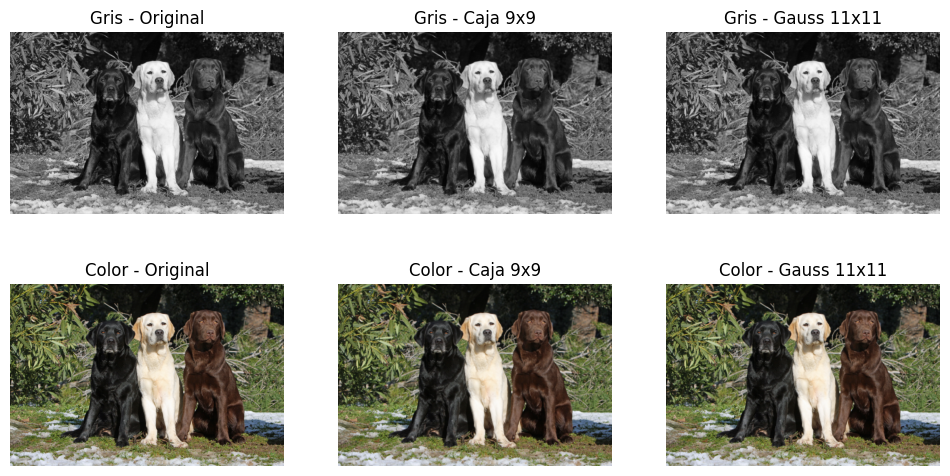

In [4]:

k_box = box_kernel(9)
k_gauss = gaussian2d(ksize=11, sigma=2.0)

blur_box_g = conv2d_gray(img_gray, k_box)
blur_box_c = conv2d_rgb(img_rgb,  k_box)

blur_gau_g = conv2d_gray(img_gray, k_gauss)
blur_gau_c = conv2d_rgb(img_rgb,  k_gauss)

plt.figure(figsize=(12,6))
plt.subplot(2,3,1); plt.imshow(tensor01_to_np_img(img_gray), cmap='gray', vmin=0, vmax=1); plt.title("Gris - Original"); plt.axis('off')
plt.subplot(2,3,2); plt.imshow(tensor01_to_np_img(blur_box_g), cmap='gray', vmin=0, vmax=1); plt.title("Gris - Caja 9x9"); plt.axis('off')
plt.subplot(2,3,3); plt.imshow(tensor01_to_np_img(blur_gau_g), cmap='gray', vmin=0, vmax=1); plt.title("Gris - Gauss 11x11"); plt.axis('off')

plt.subplot(2,3,4); plt.imshow(tensor01_to_np_img(img_rgb)); plt.title("Color - Original"); plt.axis('off')
plt.subplot(2,3,5); plt.imshow(tensor01_to_np_img(blur_box_c)); plt.title("Color - Caja 9x9"); plt.axis('off')
plt.subplot(2,3,6); plt.imshow(tensor01_to_np_img(blur_gau_c)); plt.title("Color - Gauss 11x11"); plt.axis('off')
plt.show()


## 5) Detectores de **bordes**: Sobel, Prewitt, Scharr, Roberts
Calculamos **gradiente X/Y** y su **magnitud**.


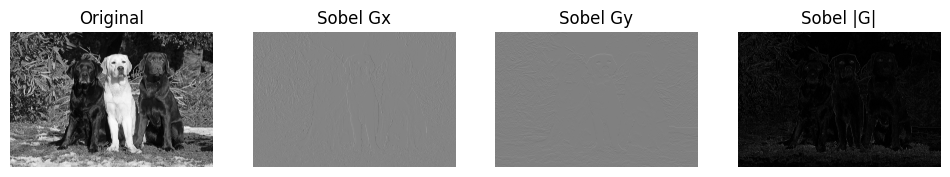

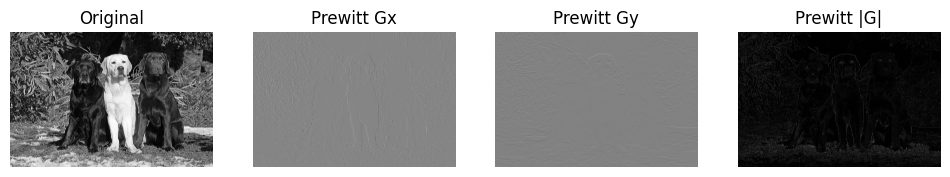

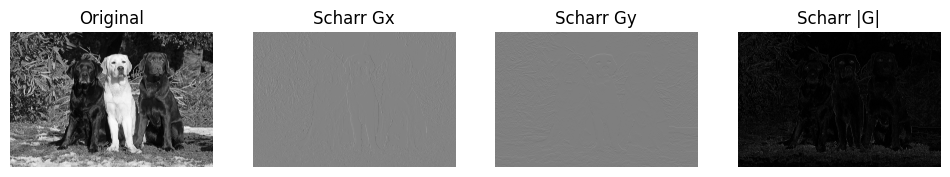

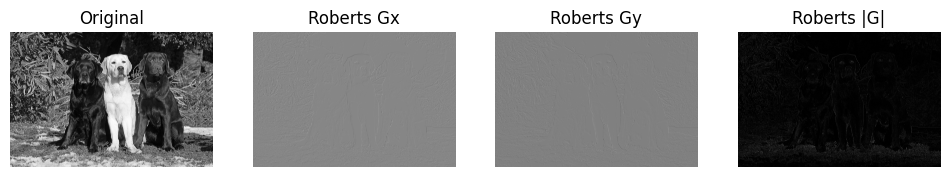

In [5]:

def grad_and_mag(gray, kx, ky, name=""):
    gx = conv2d_gray(gray, kx)
    gy = conv2d_gray(gray, ky)
    mag = torch.sqrt(gx**2 + gy**2)
    fig = plt.figure(figsize=(12,4))
    plt.subplot(1,4,1); plt.imshow(tensor01_to_np_img(gray), cmap='gray', vmin=0, vmax=1); plt.title("Original"); plt.axis('off')
    plt.subplot(1,4,2); plt.imshow(tensor01_to_np_img(rescale01(gx)), cmap='gray', vmin=0, vmax=1); plt.title(f"{name} Gx"); plt.axis('off')
    plt.subplot(1,4,3); plt.imshow(tensor01_to_np_img(rescale01(gy)), cmap='gray', vmin=0, vmax=1); plt.title(f"{name} Gy"); plt.axis('off')
    plt.subplot(1,4,4); plt.imshow(tensor01_to_np_img(rescale01(mag)), cmap='gray', vmin=0, vmax=1); plt.title(f"{name} |G|"); plt.axis('off')
    plt.show()

kx, ky = sobel_kernels()
grad_and_mag(img_gray, kx, ky, "Sobel")

kx, ky = prewitt_kernels()
grad_and_mag(img_gray, kx, ky, "Prewitt")

kx, ky = scharr_kernels()
grad_and_mag(img_gray, kx, ky, "Scharr")

kx, ky = roberts_kernels()
grad_and_mag(img_gray, kx, ky, "Roberts")


## 6) Laplaciano y Laplaciano del Gaussiano (LoG)
- **Laplaciano 4/8 vecinos** resalta transiciones independientemente de la orientación.  
- **LoG**: suaviza y luego deriva (segunda derivada), útil para localización robusta de bordes.


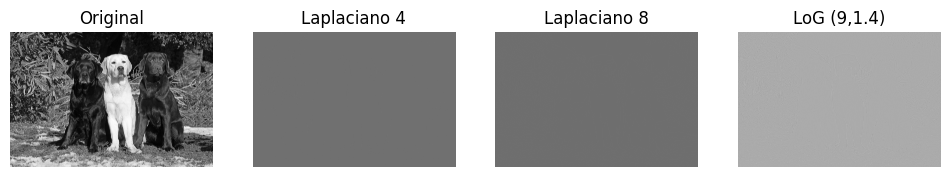

In [6]:

lap4 = laplacian4()
lap8 = laplacian8()
log9 = log_kernel(ksize=9, sigma=1.4)

lap4_img = conv2d_gray(img_gray, lap4)
lap8_img = conv2d_gray(img_gray, lap8)
log_img  = conv2d_gray(img_gray, log9)

plt.figure(figsize=(12,4))
plt.subplot(1,4,1); plt.imshow(tensor01_to_np_img(img_gray), cmap='gray', vmin=0, vmax=1); plt.title("Original"); plt.axis('off')
plt.subplot(1,4,2); plt.imshow(tensor01_to_np_img(rescale01(lap4_img)), cmap='gray', vmin=0, vmax=1); plt.title("Laplaciano 4"); plt.axis('off')
plt.subplot(1,4,3); plt.imshow(tensor01_to_np_img(rescale01(lap8_img)), cmap='gray', vmin=0, vmax=1); plt.title("Laplaciano 8"); plt.axis('off')
plt.subplot(1,4,4); plt.imshow(tensor01_to_np_img(rescale01(log_img)),  cmap='gray', vmin=0, vmax=1); plt.title("LoG (9,1.4)"); plt.axis('off')
plt.show()


## 7) Realce (Sharpen), **High-Boost** y **Emboss**
- **Sharpen básico**: resalta alta frecuencia.  
- **High-Boost**: $ I' = I + \alpha (I - G_\sigma * I) $.  
- **Emboss**: efecto relieve (cambia fase/iluminación local).


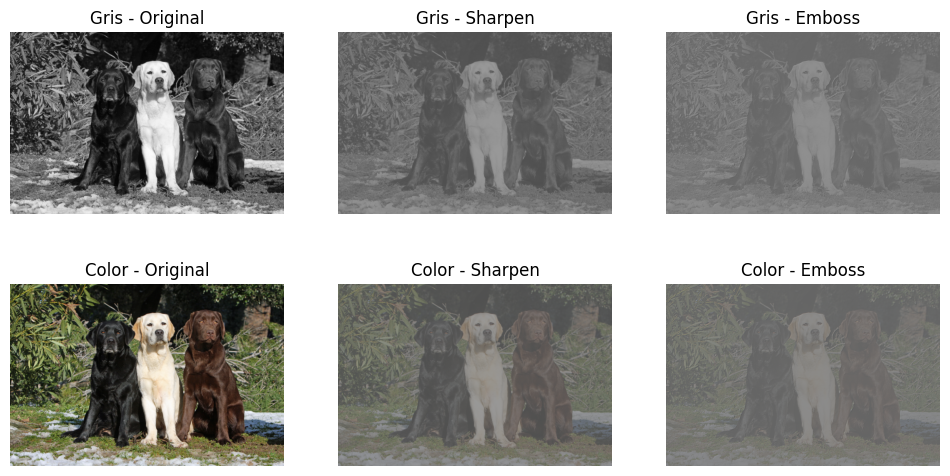

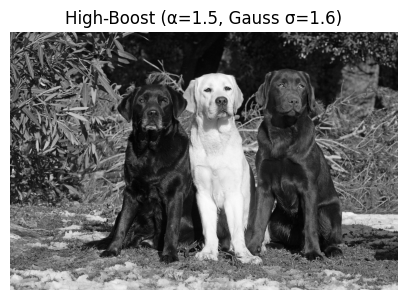

In [7]:

# Sharpen básico por kernel
sharpen_k = sharpen_basic()
sharpen_g = conv2d_gray(img_gray, sharpen_k)
sharpen_c = conv2d_rgb(img_rgb,  sharpen_k)

# High-boost con gauss (separable en 2D usando kernel 2D)
g = gaussian2d(ksize=11, sigma=1.6)
blur = conv2d_gray(img_gray, g)
amount = 1.5
highboost = (img_gray + amount*(img_gray - blur)).clamp(0,1)

# Emboss
emb = emboss()
emb_g = conv2d_gray(img_gray, emb)
emb_c = conv2d_rgb(img_rgb,  emb)

plt.figure(figsize=(12,6))
plt.subplot(2,3,1); plt.imshow(tensor01_to_np_img(img_gray), cmap='gray', vmin=0, vmax=1); plt.title("Gris - Original"); plt.axis('off')
plt.subplot(2,3,2); plt.imshow(tensor01_to_np_img(rescale01(sharpen_g)), cmap='gray', vmin=0, vmax=1); plt.title("Gris - Sharpen"); plt.axis('off')
plt.subplot(2,3,3); plt.imshow(tensor01_to_np_img(rescale01(emb_g)), cmap='gray', vmin=0, vmax=1); plt.title("Gris - Emboss"); plt.axis('off')

plt.subplot(2,3,4); plt.imshow(tensor01_to_np_img(img_rgb)); plt.title("Color - Original"); plt.axis('off')
plt.subplot(2,3,5); plt.imshow(tensor01_to_np_img(rescale01(sharpen_c))); plt.title("Color - Sharpen"); plt.axis('off')
plt.subplot(2,3,6); plt.imshow(tensor01_to_np_img(rescale01(emb_c))); plt.title("Color - Emboss"); plt.axis('off')
plt.show()

imshow_t(highboost, "High-Boost (α=1.5, Gauss σ=1.6)")


## 8) **Motion Blur** (desenfoque por movimiento)
Kernel lineal en la dirección $\theta$. Cambia `length` y `angle_deg`.


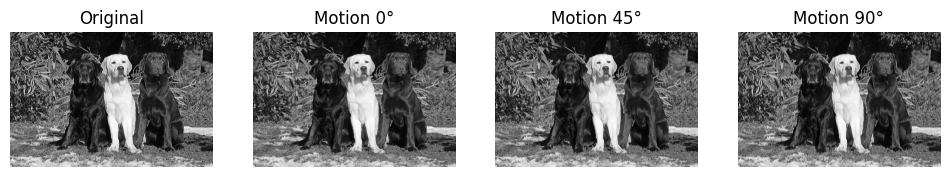

In [8]:

mb0 = motion_blur_kernel(length=17, angle_deg=0.0)
mb45 = motion_blur_kernel(length=17, angle_deg=45.0)
mb90 = motion_blur_kernel(length=17, angle_deg=90.0)

mb0_g  = conv2d_gray(img_gray, mb0)
mb45_g = conv2d_gray(img_gray, mb45)
mb90_g = conv2d_gray(img_gray, mb90)

plt.figure(figsize=(12,4))
plt.subplot(1,4,1); plt.imshow(tensor01_to_np_img(img_gray), cmap='gray', vmin=0, vmax=1); plt.title("Original"); plt.axis('off')
plt.subplot(1,4,2); plt.imshow(tensor01_to_np_img(mb0_g),  cmap='gray', vmin=0, vmax=1); plt.title("Motion 0°"); plt.axis('off')
plt.subplot(1,4,3); plt.imshow(tensor01_to_np_img(mb45_g), cmap='gray', vmin=0, vmax=1); plt.title("Motion 45°"); plt.axis('off')
plt.subplot(1,4,4); plt.imshow(tensor01_to_np_img(mb90_g), cmap='gray', vmin=0, vmax=1); plt.title("Motion 90°"); plt.axis('off')
plt.show()


## 9) **Filtros de Gabor** (banco de orientaciones)
Los Gabors actúan como detectores de **textura/orientación**. Construimos un **banco** de orientaciones y lo aplicamos.


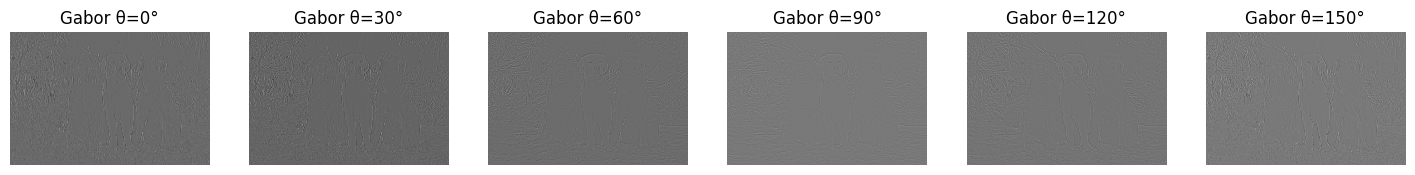

In [9]:
def gabor_kernel(ksize=21, sigma=3.0, theta=0.0, lam=10.0, gamma=0.5, psi=0.0):
    r = ksize//2
    y, x = torch.meshgrid(torch.arange(-r, r+1), torch.arange(-r, r+1), indexing='ij')
    x = x.float(); y = y.float()
    theta_t = torch.tensor(theta, dtype=torch.float32, device=x.device)

    xr =  x*theta_t.cos() + y*theta_t.sin()
    yr = -x*theta_t.sin() + y*theta_t.cos()

    gauss = torch.exp(-0.5 * ((xr**2 + (gamma*yr)**2) / (sigma**2)))
    wave  = torch.cos(2*torch.pi*xr/lam + psi)
    g = gauss * wave
    g = g - g.mean()
    return g

thetas = [0, 30, 60, 90, 120, 150]  # grados
gab_imgs = []
for th in thetas:
    gk = gabor_kernel(ksize=25, sigma=3.0, theta=th*pi/180, lam=10.0, gamma=0.6, psi=0.0)
    out = conv2d_gray(img_gray, gk)
    gab_imgs.append(rescale01(out))

cols = len(thetas)
plt.figure(figsize=(3*cols,3))
for i,(th,im) in enumerate(zip(thetas, gab_imgs), start=1):
    plt.subplot(1, cols, i)
    plt.imshow(tensor01_to_np_img(im), cmap='gray', vmin=0, vmax=1)
    plt.title(f"Gabor θ={th}°"); plt.axis('off')
plt.show()


## 10) Galería rápida de **muchos kernels** (grises)
Aplicamos una lista grande de filtros y los mostramos en una galería para comparación.


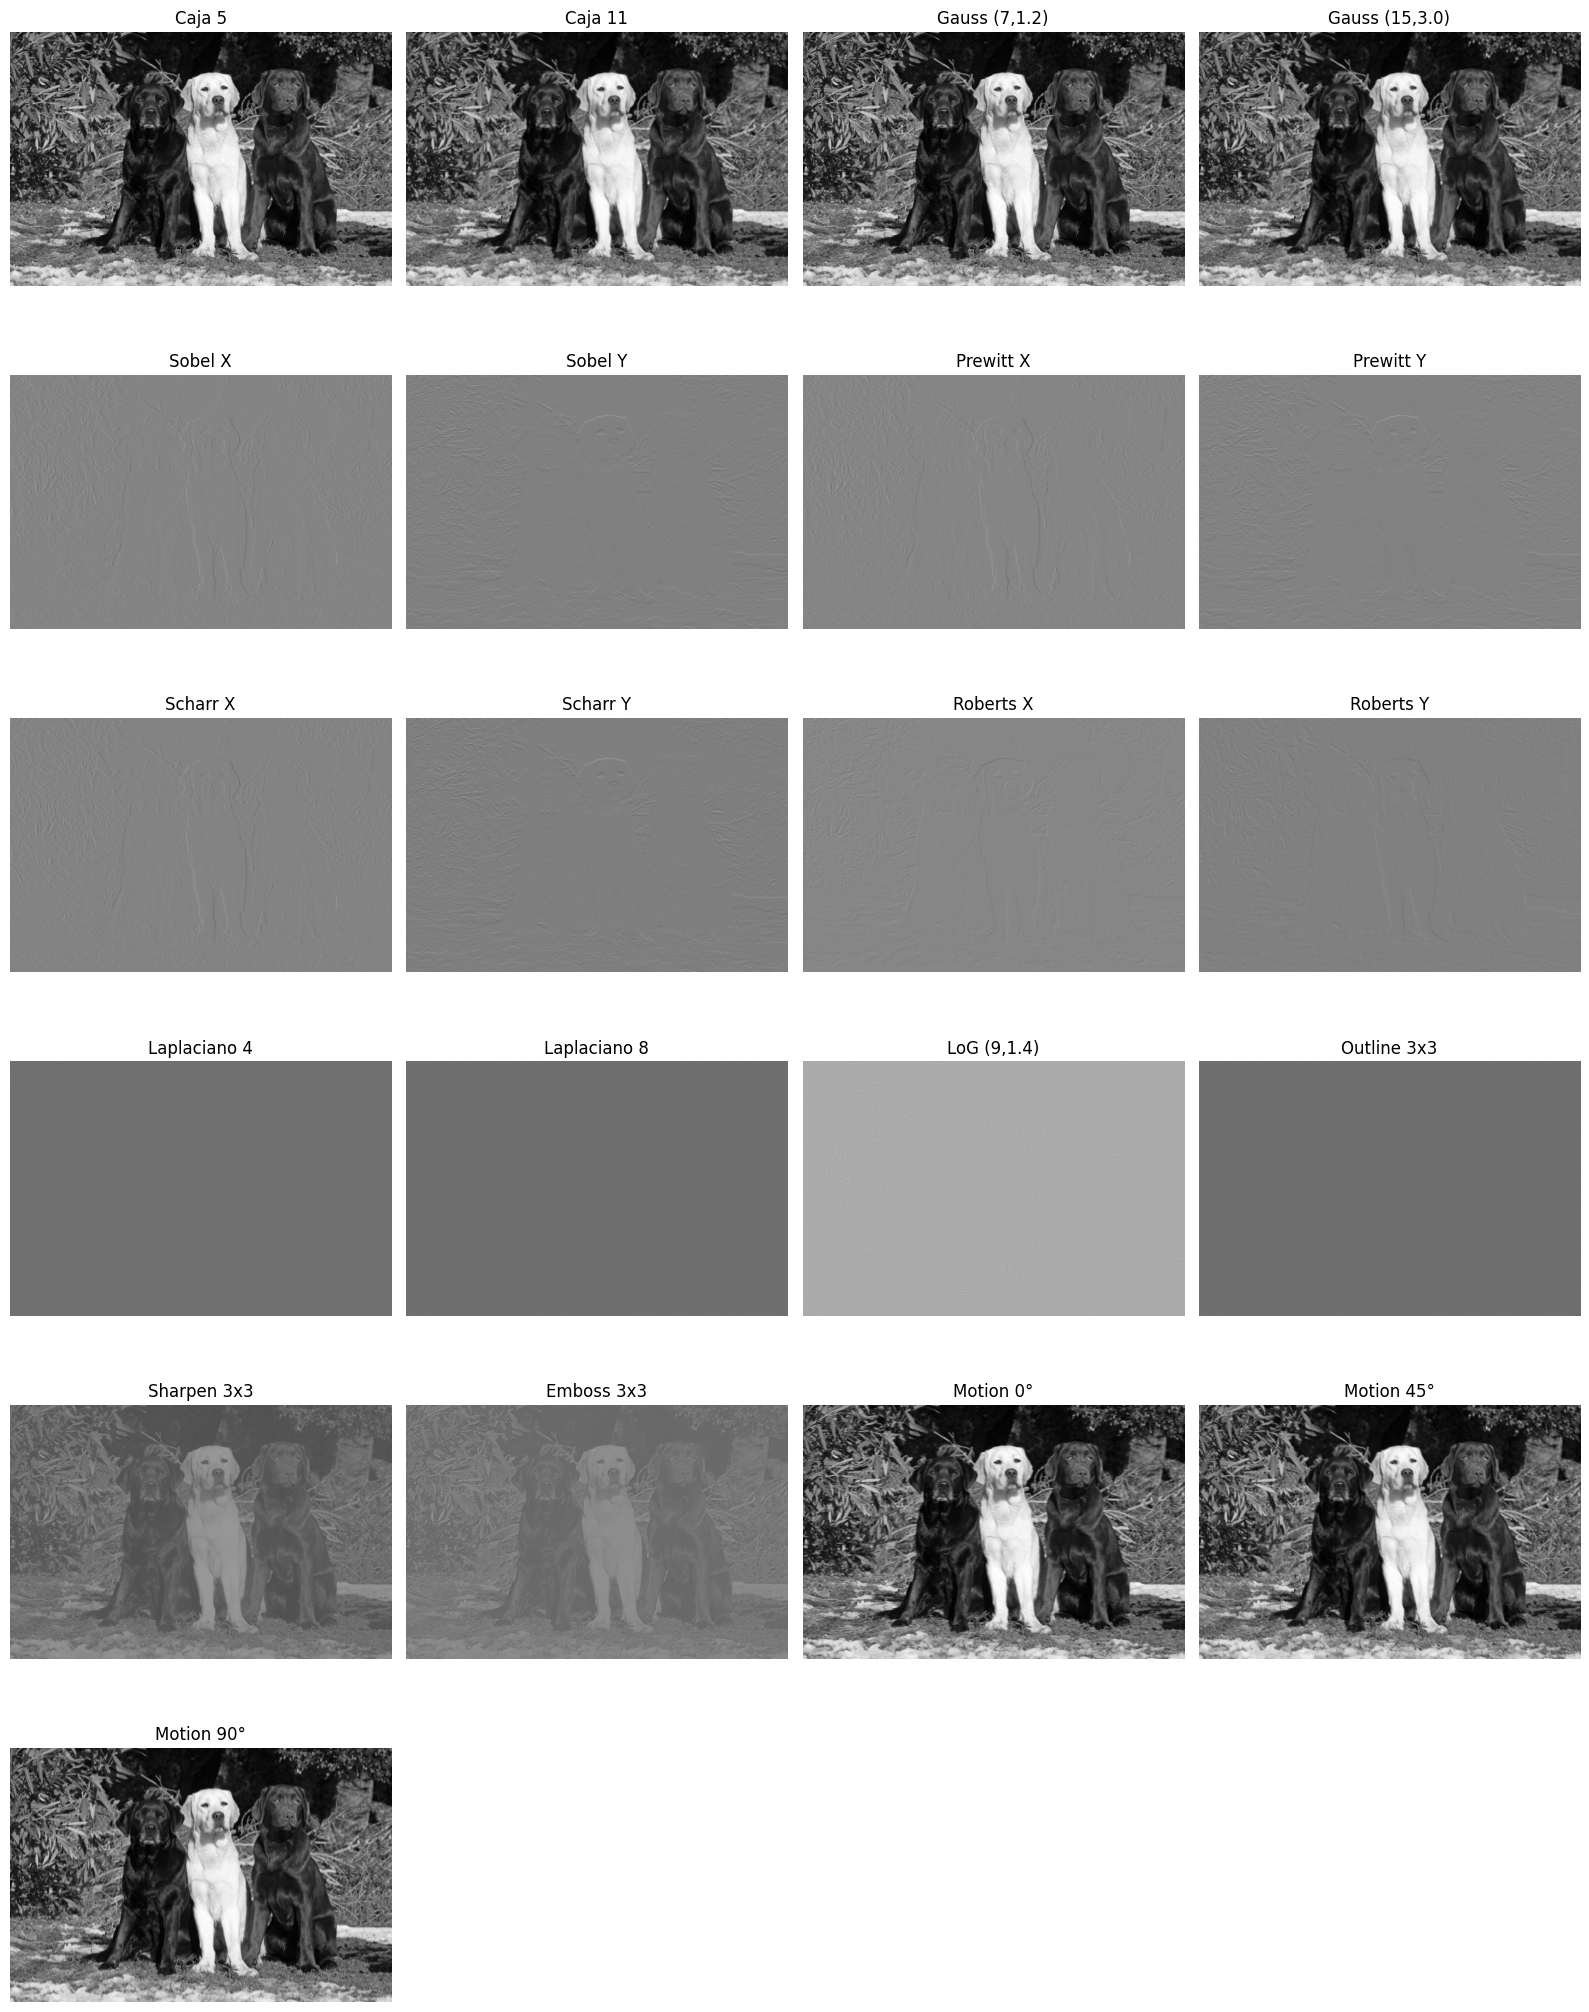

In [10]:

kernels = {
    "Caja 5": box_kernel(5),
    "Caja 11": box_kernel(11),
    "Gauss (7,1.2)": gaussian2d(7,1.2),
    "Gauss (15,3.0)": gaussian2d(15,3.0),
    "Sobel X": sobel_kernels()[0],
    "Sobel Y": sobel_kernels()[1],
    "Prewitt X": prewitt_kernels()[0],
    "Prewitt Y": prewitt_kernels()[1],
    "Scharr X": scharr_kernels()[0],
    "Scharr Y": scharr_kernels()[1],
    "Roberts X": roberts_kernels()[0],
    "Roberts Y": roberts_kernels()[1],
    "Laplaciano 4": laplacian4(),
    "Laplaciano 8": laplacian8(),
    "LoG (9,1.4)": log_kernel(9,1.4),
    "Outline 3x3": outline(),
    "Sharpen 3x3": sharpen_basic(),
    "Emboss 3x3": emboss(),
    "Motion 0°": motion_blur_kernel(15,0),
    "Motion 45°": motion_blur_kernel(15,45),
    "Motion 90°": motion_blur_kernel(15,90),
}

names = list(kernels.keys())
vals  = list(kernels.values())
outs  = [rescale01(conv2d_gray(img_gray, k)) for k in vals]

cols = 4
rows = int(np.ceil(len(outs)/cols))
plt.figure(figsize=(4*cols, 3.5*rows))
for i,(nm,im) in enumerate(zip(names, outs), start=1):
    plt.subplot(rows, cols, i)
    plt.imshow(tensor01_to_np_img(im), cmap='gray', vmin=0, vmax=1)
    plt.title(nm); plt.axis('off')
plt.tight_layout(); plt.show()


## 11) Efecto de **modos de borde**
Compara `reflect`, `replicate` y `constant` con un kernel grande.


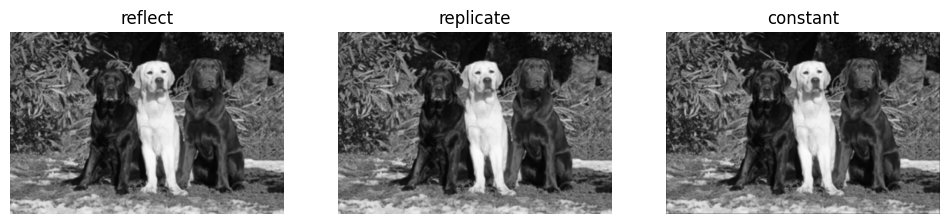

In [11]:

k = box_kernel(21)
modes = ['reflect', 'replicate', 'constant']
outs = []
for md in modes:
    outs.append(conv2d_gray(img_gray, k, pad_mode=md))

plt.figure(figsize=(12,4))
for i,(md,out) in enumerate(zip(modes, outs), start=1):
    plt.subplot(1,3,i)
    plt.imshow(tensor01_to_np_img(out), cmap='gray', vmin=0, vmax=1)
    plt.title(md); plt.axis('off')
plt.show()


## Preguntas
1. ¿Por qué algunos kernels de detección de bordes tienen **suma cero**?  
Algunos kernels de detección de bordes tienen suma cero porque están diseñados para que, en una parte de la imagen donde todo es
uniforme que es cuando los píxeles tienen la misma intensidad o color, el resultado sea cero y no se marque nada. En cambio, cuando
ocurre un cambio brusco, como pasar de una zona clara a una oscura, los valores positivos y negativos del kernel se compensan de forma
que resaltan esa diferencia.

2. ¿Cuál es el efecto de cada kernel en cada imagen? Realice una tabla compartiva.

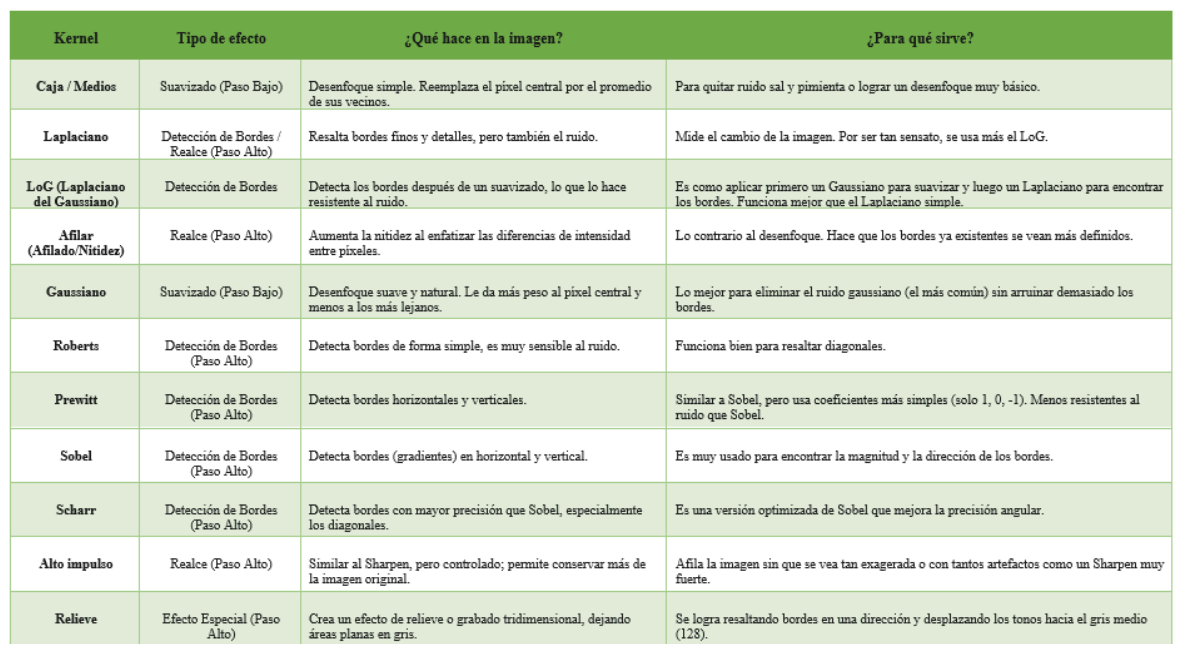